In [ ]:
# This code replicates the algorithm from Human-Level Control Through Deep Reinforcement Learning (2015 Mnih et al) https://daiwk.github.io/assets/dqn.pdf
!pip install git+https://github.com/DLR-RM/stable-baselines3
!pip install gym[atari]
!pip install autorom[accept-rom-license]
!apt-get update
!apt-get install ffmpeg libsm6 libxext6  -y
!pip install ale-py==0.7.4 
# Below line is only necessary if running on an A6000
#!pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install line_profiler
%load_ext line_profiler

In [ ]:
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)
from torch.utils.tensorboard import SummaryWriter
import copy
import time
from psutil import virtual_memory

In [ ]:
# Instantiate the neural network
class DeepQNetworkAtari(nn.Module):
  def __init__(self, env):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(4, 32, 8, stride=4),
        nn.ReLU(),
        nn.Conv2d(32, 64, 4, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3136, 512),
        nn.ReLU(),
        nn.Linear(512, env.single_action_space.n)
    )

  def forward(self, x):
    return self.network(x / 255.0) # Normalise pixel values to range [0, 1].

In [ ]:
# Instantiate the replay buffer
class ReplayBuffer:

  def __init__(self, max_frames):
    self.max_frames = max_frames
    self.buffer = np.zeros_like([0 for i in range(max_frames)], dtype=object)
    self.index = 0

  def add(self, frame):
    frame["index"] = [self.index]
    self.buffer[self.index % self.max_frames] = frame
    self.index = self.index + 1

  def sample(self, num_samples):
    experiences = np.random.choice(self.buffer[0:min(self.index-1, self.max_frames-1)], size=[num_samples], replace=True)
    return {"obs": self.transform(experiences, "obs", torch.float32, [num_samples, 4, 84, 84]),
            "next_obs": self.get_next_obs_batch(experiences),
            "actions": self.transform(experiences, "action", torch.int64, [num_samples, 1]),
            "rewards": self.transform(experiences, "reward", torch.float32, [num_samples, 1]),
            "dones": self.transform(experiences, "done", torch.float32, [num_samples, 1])}

  def transform(self, array, key, dtype, shape):
      item = [item[key] for item in array]
      item = np.array(item)
      item = torch.as_tensor(item, dtype=dtype)
      return item.reshape(shape)

  def get_next_obs_batch(self, experiences):
    indices = [experience["index"][0] if experience["done"][0] > 0 else experience["index"][0] + 1 for experience in experiences]
    next_obs_batch = [self.buffer[index % self.max_frames]["obs"] for index in indices]
    return torch.as_tensor(np.array(next_obs_batch), dtype=torch.float32).reshape(len(indices), 4, 84, 84)

In [ ]:
def make_env(env_id, seed):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return thunk

In [ ]:
# Helper functions
def plot_results(steps, rewards, total_timesteps, avg, benchmark):
  plt.plot([item for item in get_rolling_average(steps, avg)], 
          [item for item in get_rolling_average(rewards, avg)])
  max_x = [0, total_timesteps]
  max_y = [benchmark, benchmark] # Cartpole max.
  plt.plot(max_x, max_y, color='r', ls=':')
  plt.xlabel(f"Number of Steps (Avg. {avg})")
  plt.ylabel(f"Current Return (Avg. {avg})")
  plt.show()

def get_rolling_average(items, num):
    rolling = []
    for i in range(len(items)-num):
        rolling.append(sum(items[i:i+num])/num)
    return rolling

def calculate_epsilon(step, epsilon_start, epsilon_finish, 
                      total_timesteps, exploration_fraction):
  finish_step = total_timesteps * exploration_fraction
  if step > finish_step:
    return epsilon_finish
  epsilon_range = epsilon_start - epsilon_finish
  return epsilon_finish + (((finish_step - step) / finish_step) * epsilon_range)

def print_colab_info():
  # Print GPU and RAM info for Colab instance.
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

In [7]:
def train(env, total_timesteps, batch_size, buffer_size, train_frequency, seed,
          target_network_update_frequency,  gamma, learning_rate, epsilon_start, 
          epsilon_finish, exploration_fraction, learn_start_size):
  
  env = gym.vector.SyncVectorEnv([make_env(env, seed)])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  print(device)
  print_colab_info()

  writer = SummaryWriter(f"runs/test")
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True if seed > 0 else False

  # Initialise replay memory D to capacity N
  buffer = ReplayBuffer(buffer_size)

  # Initialize action-value function Q and target network.
  q_network = DeepQNetworkAtari(env).to(device)
  target_network = DeepQNetworkAtari(env).to(device)
  target_network.load_state_dict(q_network.state_dict())
  optimiser = torch.optim.Adam(q_network.parameters(), learning_rate)

  obs = env.reset()
  episode_end_steps = []
  episode_rewards = []
  start_time = time.time()

  for step in range(total_timesteps):

    # Select random action with p(epsilon), else argmax(q).
    epsilon = calculate_epsilon(step, epsilon_start, epsilon_finish, 
                                total_timesteps, exploration_fraction)
    
    if random.random() < epsilon:
      action = env.action_space.sample()
    else:
      logits = q_network(torch.Tensor(obs).to(device))
      action = torch.argmax(logits, dim=1).cpu().numpy()

    next_obs, reward, done, info = env.step(action)
    next_obs_copy = next_obs.copy()

    # Store transition in D. (Note: Can halve memory here by not storing next_obs and instead pointing to obs[index+1] in buffer?)
    buffer.add({"obs": obs, "action": [action], "reward": [reward], "done": [1. if done else 0.], "info": info})
    
    if done and "episode" in info[0].keys():
        print(f"global_step={step}, episodic_return={info[0]['episode']['r']}")
        writer.add_scalar("charts/episodic_return", info[0]["episode"]["r"], step)
        writer.add_scalar("charts/episodic_length", info[0]["episode"]["l"], step)
        writer.add_scalar("charts/epsilon", epsilon, step)
        episode_end_steps.append(step)
        episode_rewards.append(info[0]['episode']['r'])
        obs = env.reset()
        continue

    obs = next_obs

    if step > learn_start_size and step % train_frequency == 0:
    
      # Sample replay experiences.
      experiences = buffer.sample(batch_size)
      experiences = {i:j.to(device) for (i, j) in experiences.items()}

      with torch.no_grad(): # We want to sample the Q-network here, but not update it yet.

        # Changing target_network to q_network here implements DDQN, which is superior.
        target_max, _ = q_network(experiences["next_obs"]).max(dim=1) # The _ removes the indices we don't want, leaving only the values.
        td_target = experiences["rewards"].flatten() + gamma * target_max * (1 - experiences["dones"].flatten())

      # Collect tensor of predicted rewards associated with the actions taken.
      old_val = q_network(experiences["obs"]).gather(1, experiences["actions"]).squeeze()

      # Calculate loss
      loss = F.mse_loss(td_target, old_val)

      # Gradient descent
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      # Logs
      if step % 1000 == 0:
          writer.add_scalar("losses/td_loss", loss, step)
          writer.add_scalar("losses/q_values", old_val.mean().item(), step)
          print("SPS:", int(step / (time.time() - start_time)))
          writer.add_scalar("charts/SPS", int(step / (time.time() - start_time)),step)

    # Update target network.
    if step % target_network_update_frequency == 0:
      target_network.load_state_dict(q_network.state_dict())

  env.close()
  plot_results(episode_end_steps, episode_rewards, total_timesteps, 50, 168)

train(env='BreakoutNoFrameskip-v4', total_timesteps=10000000, batch_size=32, buffer_size=1000000, train_frequency=4, seed=1, target_network_update_frequency=1000, gamma=0.99, learning_rate=1e-4, epsilon_start=1, epsilon_finish=0.01, exploration_fraction=0.1, learn_start_size=80000)

Results compared to CleanRL (same seed). CleanRL is at the top, this code is at the bottom.

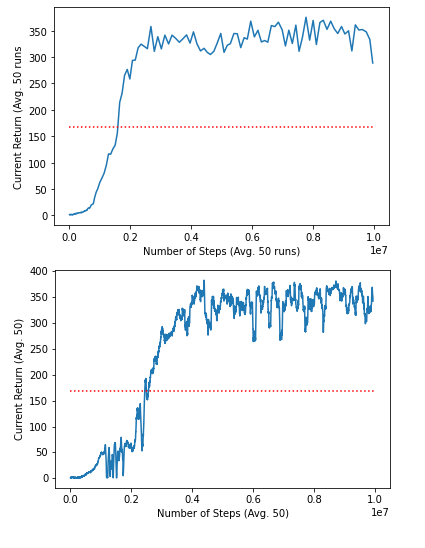